In [1]:
# Install dependencies for PyTorch StarDist (and UNet tools)
# Note: Removed 'btrack==0.6.5' pin to resolve dependency conflicts with laptrack
# Note: 'numpy<2' is required. Reinstalling PyTorch to ensure binary compatibility.
# Note: Switched to 'pip' with --prefer-binary to speed up installation and show progress.
!pip uninstall -y torch torchvision torchaudio
!pip install "numpy<2" torch torchvision cellseg-models-pytorch pytorch-lightning laptrack btrack "albumentations==1.3.1" opencv-python-headless pandas scipy scikit-image scikit-learn matplotlib seaborn tqdm ipywidgets tifffile numba --prefer-binary

# Uninstall TensorFlow/StarDist to avoid conflicts
!pip uninstall -y tensorflow tensorflow-intel tensorflow-cpu stardist csbdeep || true

import torch
import sys
print(f"PyTorch version: {torch.__version__}, CUDA: {torch.cuda.is_available()}")
try:
    import cellseg_models_pytorch
    from cellseg_models_pytorch.models.stardist.stardist import StarDist
    import pytorch_lightning as pl
    print("PyTorch StarDist libraries installed successfully.")
except ImportError as e:
    print(f"Installation failed: {e}")

Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1
Found existing installation: torchvision 0.24.1
Uninstalling torchvision-0.24.1:
  Successfully uninstalled torchvision-0.24.1
  Using cached torch-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.24.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
Using cached torch-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl (899.7 MB)
Using cached torchvision-0.24.1-cp312-cp312-manylinux_2_28_x86_64.whl (8.0 MB)
PyTorch version: 2.9.1+cu128, CUDA: True


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


PyTorch StarDist libraries installed successfully.


In [2]:
# @title Imports & Globals
import os
import math
import shutil
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from skimage.measure import label, regionprops
from skimage.draw import disk
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Tracking
try:
    import laptrack
    from laptrack import LapTrack
    print("LapTrack available.")
except ImportError:
    print("LapTrack not found.")

# PyTorch StarDist
try:
    from cellseg_models_pytorch.models.stardist.stardist import StarDist
    from cellseg_models_pytorch.transforms.functional.stardist import gen_stardist_maps
    from cellseg_models_pytorch.postproc.functional.stardist.stardist import post_proc_stardist
    HAS_STARDIST_TORCH = True
except ImportError:
    HAS_STARDIST_TORCH = False
    print("Warning: cellseg-models-pytorch not found. StarDist cells will fail.")

# ROI constants
ROI_Y_MIN, ROI_Y_MAX = 512, 768
ROI_X_MIN, ROI_X_MAX = 256, 512
ROI_H, ROI_W = ROI_Y_MAX - ROI_Y_MIN, ROI_X_MAX - ROI_X_MIN

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")


LapTrack available.
Using device: cuda


In [3]:
# @title StarDist Setup (PyTorch)
if not HAS_STARDIST_TORCH:
    print("Installing cellseg-models-pytorch...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cellseg-models-pytorch"])
    from cellseg_models_pytorch.models.stardist.stardist import StarDist
    from cellseg_models_pytorch.transforms.functional.stardist import gen_stardist_maps
    from cellseg_models_pytorch.postproc.functional.stardist.stardist import post_proc_stardist
    print("Installed and imported.")
else:
    print("StarDist (PyTorch) is ready.")


StarDist (PyTorch) is ready.


In [4]:
# @title Data Download Helpers (validation + optional Drive training)
import os, shutil, zipfile, requests

# Download validation video+labels zip (with SSL chain)
def download_validation_data(target_dir: str = "val_data",
                             url: str = "https://su2.utia.cas.cz/files/labs/final2025/val_and_sota.zip",
                             cert_url: str = "https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem"):
    if os.path.exists(target_dir) and len(os.listdir(target_dir)) > 0:
        print(f"'{target_dir}' already exists. Skipping download.")
        return

    chain_path = "chain-harica-cross.pem"
    print("1) Downloading SSL certificate chain...")
    r = requests.get(cert_url, timeout=10, stream=True)
    r.raise_for_status()
    with open(chain_path, "wb") as f:
        f.write(r.content)
    print("2) Downloading validation archive...")
    zip_name = os.path.basename(url)
    with requests.get(url, stream=True, verify=chain_path, timeout=30) as resp:
        resp.raise_for_status()
        with open(zip_name, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("3) Extracting...")
    os.makedirs(target_dir, exist_ok=True)
    with zipfile.ZipFile(zip_name, "r") as zf:
        zf.extractall(target_dir)
    os.remove(zip_name)
    print(f"Done. Data in '{target_dir}/'")


# Optional: copy training data from Google Drive (manual annotations)
def fetch_from_drive(DRIVE_SOURCE_PATH: str = "/content/drive/MyDrive/unet_train",
                     TARGET_DIR: str = "real_training_data"):
    try:
        from google.colab import drive
    except ImportError:
        print("google.colab not available (not running in Colab).")
        return

    print("?? Mounting Drive...")
    drive.mount('/content/drive')

    if os.path.exists(TARGET_DIR) and len(os.listdir(TARGET_DIR)) > 0:
        print(f"'{TARGET_DIR}' already exists and is not empty. Skipping copy.")
        return

    if not os.path.exists(DRIVE_SOURCE_PATH):
        print(f"? Source not found: {DRIVE_SOURCE_PATH}")
        return

    print(f"Copying {DRIVE_SOURCE_PATH} -> {TARGET_DIR}")
    try:
        shutil.copytree(DRIVE_SOURCE_PATH, TARGET_DIR)
        print("? Copy complete.")
    except Exception as e:
        print(f"? Copy failed: {e}")
        if os.path.exists(TARGET_DIR):
            shutil.rmtree(TARGET_DIR)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Canonical UNet used everywhere in the notebook
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        if self.dropout:
            x = self.dropout(x)
        return x


class LightweightUNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=1, features=(32, 64, 128, 256), dropout_rate=0.2):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_ch = in_channels
        for idx, feature in enumerate(features):
            current_dropout = dropout_rate if idx == len(features) - 1 else 0.0
            self.downs.append(ConvBlock(in_ch, feature, dropout_rate=current_dropout))
            in_ch = feature

        self.bottleneck = ConvBlock(features[-1], features[-1] * 2, dropout_rate=dropout_rate)

        for idx, feature in enumerate(reversed(features)):
            current_dropout = dropout_rate if idx == 0 else 0.0
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(ConvBlock(feature * 2, feature, dropout_rate=current_dropout))

        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)
            x = self.ups[idx + 1](torch.cat((skip_connection, x), dim=1))

        return self.final_conv(x)


def build_unet(in_channels: int = 1, n_classes: int = 1, features=(32, 64, 128, 256), dropout_rate: float = 0.2) -> LightweightUNet:
    return LightweightUNet(in_channels=in_channels, n_classes=n_classes, features=features, dropout_rate=dropout_rate)


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


class ComboLoss(nn.Module):
    def __init__(self, focal_weight: float = 0.5, dice_weight: float = 0.5, alpha: float = 0.75, gamma: float = 2.0):
        super().__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.focal = FocalLoss(alpha=alpha, gamma=gamma) if focal_weight > 0 else None

    def dice_loss(self, pred, target, eps=1e-6):
        pred = torch.sigmoid(pred)
        smooth = 1.0
        intersection = (pred * target).sum()
        dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth + eps)
        return 1 - dice

    def forward(self, inputs, targets):
        if isinstance(inputs, list):
            losses = [self.forward(item, targets) for item in inputs]
            return sum(losses) / len(losses)

        loss = 0.0
        denom = 0.0
        if self.focal and self.focal_weight > 0:
            loss += self.focal_weight * self.focal(inputs, targets)
            denom += self.focal_weight
        if self.dice_weight > 0:
            loss += self.dice_weight * self.dice_loss(inputs, targets)
            denom += self.dice_weight
        if denom == 0:
            raise ValueError("At least one of focal_weight or dice_weight must be > 0.")
        return loss / denom


# Quick sanity check to ensure shapes stay consistent
_dummy = torch.randn(1, 1, 256, 256)
_model = build_unet()
_out = _model(_dummy)
print(f"Model ok, output shape: {_out.shape}")


Model ok, output shape: torch.Size([1, 1, 256, 256])


In [6]:
# @title Data prep: build experiment_dataset (StarDist masks)

def create_stardist_label_mask(image_shape: Tuple[int, int], points, radius: int = 6) -> np.ndarray:
    '''Convert center points into a StarDist-ready integer mask.

    The mask is a solid disk per point (no hollow centers), assigning a unique
    integer id to every object. Out-of-bounds points are skipped.f
    '''
    label_mask = np.zeros(image_shape, dtype=np.uint16)
    current_id = 1
    for (y, x) in points:
        if y < 0 or x < 0 or y >= image_shape[0] or x >= image_shape[1]:
            continue
        rr, cc = disk((y, x), radius, shape=image_shape)
        label_mask[rr, cc] = current_id
        current_id += 1
    return label_mask


def _label_connected(mask: np.ndarray) -> np.ndarray:
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return label(mask > 0).astype(np.uint16)


def prepare_grand_dataset(
    real_data_dir: str = "real_training_data",
    val_tif_path: str = "val_data/val.tif",
    val_csv_path: str = "val_data/val.csv",
    out_dir: str = "experiment_dataset",
    roi_y: Tuple[int, int] = (ROI_Y_MIN, ROI_Y_MAX),
    roi_x: Tuple[int, int] = (ROI_X_MIN, ROI_X_MAX),
    disk_radius: int = 6,
) -> Path:
    out_path = Path(out_dir)
    bonus_images = out_path / "bonus" / "images"
    bonus_masks = out_path / "bonus" / "masks"
    video_images = out_path / "video" / "images"
    video_masks = out_path / "video" / "masks"

    if out_path.exists():
        shutil.rmtree(out_path)
    for p in [bonus_images, bonus_masks, video_images, video_masks]:
        p.mkdir(parents=True, exist_ok=True)

    src_images = Path(real_data_dir) / "images"
    src_masks = Path(real_data_dir) / "masks"
    if not src_images.exists() or not src_masks.exists():
        raise FileNotFoundError("real_training_data must contain images/ and masks/")

    mask_lookup = {m.stem: m for m in src_masks.glob("*")}
    for img_path in sorted(src_images.glob("*")):
        # Assume masks are named frame_XXXX_mask.png for images frame_XXXX.png
        expected_mask_stem = f"{img_path.stem}_mask"
        mask_path = mask_lookup.get(expected_mask_stem)
        if mask_path is None:
            raise FileNotFoundError(f"Missing mask for {img_path.name} in {src_masks} (expected mask stem: {expected_mask_stem})")
        shutil.copy(img_path, bonus_images / img_path.name)
        bonus_mask_raw = _load_mask_image(mask_path)
        instance_mask = _label_connected(bonus_mask_raw)
        tifffile.imwrite(bonus_masks / f"{img_path.stem}.tif", instance_mask)

    if not Path(val_tif_path).exists():
        raise FileNotFoundError(f"Missing video file: {val_tif_path}")
    if not Path(val_csv_path).exists():
        raise FileNotFoundError(f"Missing CSV file: {val_csv_path}")

    video = tifffile.imread(val_tif_path)
    coords = pd.read_csv(val_csv_path)
    y_min, y_max = roi_y
    x_min, x_max = roi_x
    records: List[dict] = []

    for idx, frame in enumerate(video):
        crop = frame[y_min:y_max, x_min:x_max]
        points = [(int(row['y'] - y_min), int(row['x'] - x_min)) for _, row in coords[coords['frame'] == idx].iterrows()]
        mask = create_stardist_label_mask((ROI_H, ROI_W), points, radius=disk_radius)

        video_images_idx_path = video_images / f"frame_{idx:03d}.png"
        video_masks_idx_path = video_masks / f"frame_{idx:03d}.tif"
        cv2.imwrite(str(video_images_idx_path), crop)
        tifffile.imwrite(str(video_masks_idx_path), mask)
        records.append({
            'filename': video_images_idx_path.name,
            'real_frame_idx': idx,
        })

    video_map_df = pd.DataFrame(records)
    video_map_df.to_csv(out_path / "video_map.csv", index=False)

    print(f"Dataset written to {out_path}")
    print(f"Bonus samples: {len(list(bonus_images.glob('*')))} | Video frames: {len(records)}")
    return out_path

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

def get_train_transforms(
    rotate_p: float = 0.7,
    hflip_p: float = 0.5,
    vflip_p: float = 0.5,
    clahe_p: float = 0.5,
    brightness_p: float = 0.5,
    gauss_p: float = 0.3,
    elastic_p: float = 0.2,
    coarse_p: float = 0.5,
    coarse_max_holes: int = 16,
    coarse_min_holes: int = 8,
    coarse_max_hw: int = 16,
    coarse_min_hw: int = 8,
    crop_scale_min: float = 0.8,
    crop_scale_max: float = 1.0,
    crop_ratio_min: float = 0.9,
    crop_ratio_max: float = 1.1,
):
    return A.Compose([
        A.Rotate(limit=180, p=rotate_p),
        A.HorizontalFlip(p=hflip_p),
        A.VerticalFlip(p=vflip_p),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=clahe_p),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=brightness_p),
        A.GaussNoise(var_limit=(10.0, 50.0), p=gauss_p),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=elastic_p),
        A.CoarseDropout(
            max_holes=coarse_max_holes, max_height=coarse_max_hw, max_width=coarse_max_hw,
            min_holes=coarse_min_holes, min_height=coarse_min_hw, min_width=coarse_min_hw,
            fill_value=0, mask_fill_value=0, p=coarse_p,
        ),
        A.RandomResizedCrop(
            height=256,
            width=256,
            scale=(crop_scale_min, crop_scale_max),
            ratio=(crop_ratio_min, crop_ratio_max),
            p=0.5,
        ),
        A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0),
        ToTensorV2(),
    ])


def get_val_transforms():
    return A.Compose([ToTensorV2()])


def _load_gray_image(path: Path) -> np.ndarray:
    if path.suffix.lower() in {'.tif', '.tiff'}:
        arr = tifffile.imread(path)
    else:
        arr = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if arr is None:
        raise FileNotFoundError(f"Missing image: {path}")
    if arr.ndim == 3:
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
    return arr


def _load_mask_image(path: Path) -> np.ndarray:
    if path.suffix.lower() in {'.tif', '.tiff'}:
        mask = tifffile.imread(path)
    else: # Handle PNG or other image formats for masks
        mask = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise FileNotFoundError(f"Missing mask: {path}")
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return mask


class AugmentedMicroscopyDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, return_meta: bool = False, mask_mode: str = "binary"):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.return_meta = return_meta
        self.mask_mode = mask_mode
        self.image_paths = sorted(self.root_dir.joinpath("images").glob("*"))
        mask_candidates = {}
        masks_root = self.root_dir.joinpath("masks")
        for ext in ("*.tif", "*.tiff", "*.png"):
            for p in masks_root.glob(ext):
                mask_candidates[p.stem] = p
        self.mask_paths = []
        for img_path in self.image_paths:
            mask_path = mask_candidates.get(img_path.stem)
            if mask_path is None:
                raise FileNotFoundError(f"No mask found for {img_path.name} in {masks_root}")
            self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = _load_gray_image(img_path)
        mask = _load_mask_image(mask_path)

        if self.mask_mode == "binary":
            mask = (mask > 0).astype(np.uint8) * 255
        elif self.mask_mode == "label":
            mask = mask.astype(np.uint16)
        else:
            mask = mask.astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img.astype(np.uint8), mask=mask.astype(mask.dtype))
            img, mask = augmented["image"], augmented["mask"]
            if isinstance(img, torch.Tensor):
                img = img.float()
                if img.max() > 1:
                    img = img / 255.0
            if isinstance(mask, torch.Tensor):
                if self.mask_mode == "label":
                    mask = mask.long()
                else:
                    mask = mask.float()
                    if mask.max() > 1:
                        mask = mask / 255.0
                    if self.mask_mode == "binary":
                        mask = (mask > 0.5).float()
        else:
            img = torch.from_numpy(img).float().unsqueeze(0) / 255.0
            if self.mask_mode == "label":
                mask = torch.from_numpy(mask).long().unsqueeze(0)
            else:
                mask = torch.from_numpy((mask > 0).astype(np.float32)).unsqueeze(0)

        while mask.ndim < 3:
            mask = mask.unsqueeze(0)

        if self.return_meta:
            meta = {'filename': img_path.name}
            return img, mask, meta
        else:
            return img, mask


In [8]:
import torch.nn as nn
import torch.nn.functional as F


def make_fold_loaders(video_root: Path, bonus_root: Path, train_idx, val_idx, batch_size=8, num_workers=2, use_bonus: bool = True, train_transform=None, val_transform=None):
    train_tf = train_transform if train_transform is not None else get_train_transforms()
    val_tf = val_transform if val_transform is not None else get_val_transforms()
    train_ds = Subset(AugmentedMicroscopyDataset(video_root, transform=train_tf, mask_mode="binary"), train_idx)
    val_ds = Subset(AugmentedMicroscopyDataset(video_root, transform=val_tf, mask_mode="binary"), val_idx)
    datasets = [train_ds]
    bonus_len = 0
    if use_bonus:
        bonus_ds = AugmentedMicroscopyDataset(bonus_root, transform=train_tf, mask_mode="binary")
        datasets.append(bonus_ds)
        bonus_len = len(bonus_ds)
    train_loader = DataLoader(ConcatDataset(datasets), batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=max(1, batch_size // 2), shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f"Train loader: video {len(train_idx)} + bonus {bonus_len} = {len(train_loader.dataset)}")
    print(f"Val loader: {len(val_idx)}")
    return train_loader, val_loader


def train_one_fold(model, train_loader, val_loader, device, epochs=40, lr=1e-3):
    import copy
    criterion = ComboLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device).float(), masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[-1]
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device).float(), masks.to(device).float()
                outputs = model(imgs)
                if isinstance(outputs, (list, tuple)):
                    outputs = outputs[-1]
                loss = criterion(outputs, masks)
                val_loss += loss.item() * imgs.size(0)
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch:03d}: train {train_loss:.4f} | val {val_loss:.4f} | best {best_val:.4f}")
    model.load_state_dict(best_state)
    return model, best_val


from skimage.feature import peak_local_max


def infer_fold_oof(model, val_indices, video_root: Path, video_map: Path, device, threshold: float = 0.5, min_distance_peaks: int = 5):
    infer_ds = Subset(AugmentedMicroscopyDataset(video_root, transform=get_val_transforms(), return_meta=True, mask_mode="binary"), val_indices)
    infer_loader = DataLoader(infer_ds, batch_size=1, shuffle=False)
    frame_lookup = pd.read_csv(video_map).set_index('filename')['real_frame_idx'].to_dict()
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs, _, meta in infer_loader:
            filenames = meta['filename'] if isinstance(meta, dict) else [m['filename'] for m in meta]
            imgs = imgs.to(device).float()
            outputs = model(imgs)
            if isinstance(outputs, (list, tuple)):
                outputs = outputs[-1]
            probs = torch.sigmoid(outputs).cpu().numpy()
            for b in range(probs.shape[0]):
                prob_map = probs[b, 0]
                coordinates = peak_local_max(prob_map, min_distance=min_distance_peaks, threshold_abs=threshold, exclude_border=False)
                for cy, cx in coordinates:
                    preds.append({'frame': int(frame_lookup[filenames[b]]), 'x': float(cx + ROI_X_MIN), 'y': float(cy + ROI_Y_MIN)})
    return preds


def track_predictions(oof_df: pd.DataFrame, run_btrack: bool, btrack_config, btrack_radius: float, save_dir: str, label: str = "unet"):
    import sys
    if oof_df is None or len(oof_df) == 0:
        print(f"No detections to track for {label}.")
        return pd.DataFrame()

    max_frame = int(oof_df['frame'].max()) if 'frame' in oof_df.columns else -1
    detections_per_frame = [[] for _ in range(max_frame + 1)]
    for _, row in oof_df.iterrows():
        detections_per_frame[int(row['frame'])].append((float(row['x']), float(row['y'])))

    tracks_df = None
    if run_btrack and 'btrack' in sys.modules and btrack_config is not None:
        from btrack.config import load_config
        import btrack

        cfg = load_config(btrack_config) if isinstance(btrack_config, str) else btrack_config
        if cfg is None:
            cfg = btrack.config.cell_config()

        btrack_detections = [{'x': r['x'], 'y': r['y'], 'frame': int(r['frame'])} for r in oof_df.to_dict(orient='records')]
        objects = btrack.utils.create_objects_from_array(btrack_detections, properties=['x', 'y'])
        with btrack.BayesianTracker(cfg, volume=((0, 1024), (0, 1024), (-1000, 1000))) as tracker:
            tracker.append(objects)
            tracker.track()
            tracks = tracker.to_pandas().drop(columns=['z', 't', 'ID'])
        tracks_df = tracks.rename(columns={'x': 'x', 'y': 'y', 'frame': 'frame', 'track_id': 'track_id'})
    else:
        tracks_df = link_detections(detections_per_frame, max_dist=btrack_radius)

    if tracks_df is None or tracks_df.empty:
        print(f"No tracks generated for {label}.")
        return pd.DataFrame()

    out_path = Path(save_dir) / f"tracks_{label}.csv"
    tracks_df.to_csv(out_path, index=False)
    print(f"Tracks saved to {out_path}")
    return tracks_df


def _filter_roi_frames(df: pd.DataFrame, frames_filter=None, roi=None):
    if frames_filter is not None:
        frame_set = set(map(int, frames_filter))
        df = df[df.frame.isin(frame_set)]
    if roi is not None:
        y_min, y_max, x_min, x_max = roi
        df = df[(df.y >= y_min) & (df.y < y_max) & (df.x >= x_min) & (df.x < x_max)]
    return df


def hota_metric(gt: pd.DataFrame, tr: pd.DataFrame, threshold: float = 5.0):
    return hota(gt, tr, threshold=threshold)


def link_detections(detections_per_frame, max_dist: float = 7.0):
    next_id = 0
    active = {}
    records = []
    for frame_idx, dets in enumerate(detections_per_frame):
        assigned = [False] * len(dets)
        new_active = {}
        for tid, (tx, ty, lf) in list(active.items()):
            best = None; best_d = max_dist
            for i, (x, y) in enumerate(dets):
                if assigned[i]:
                    continue
                d = ((x - tx) ** 2 + (y - ty) ** 2) ** 0.5
                if d < best_d:
                    best_d = d; best = i
            if best is not None:
                assigned[best] = True
                new_active[tid] = (dets[best][0], dets[best][1], frame_idx)
                records.append({'frame': frame_idx, 'x': dets[best][0], 'y': dets[best][1], 'track_id': tid})
        for i, (x, y) in enumerate(dets):
            if not assigned[i]:
                tid = next_id; next_id += 1
                new_active[tid] = (x, y, frame_idx)
                records.append({'frame': frame_idx, 'x': x, 'y': y, 'track_id': tid})
        active = new_active
    return pd.DataFrame(records)


def track_detections_simple(preds: pd.DataFrame, max_dist: float):
    max_frame = int(preds.frame.max()) if len(preds) else -1
    dets = [[] for _ in range(max_frame + 1)]
    for _, r in preds.iterrows():
        dets[int(r.frame)].append((float(r.x), float(r.y)))
    tracks_df = link_detections(dets, max_dist=max_dist)
    return tracks_df


def show_val_overlay(model, dataset, val_indices, device: str, threshold: float = 0.5):
    import numpy as np
    if len(val_indices) == 0:
        print("No validation indices to visualize")
        return
    idx = int(np.random.choice(val_indices))
    img, mask = dataset[idx]
    if isinstance(img, tuple):
        img = img[0]
    base = img.squeeze().cpu().numpy()
    if base.max() > 1:
        base = base / 255.0
    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device).float())
        if isinstance(out, (list, tuple)):
            out = out[-1]
        prob = torch.sigmoid(out)[0, 0].cpu().numpy()
    bin_mask = (prob >= threshold).astype(float)
    gt_mask = mask.squeeze().cpu().numpy()
    gt_props = regionprops(label(gt_mask > 0.5)); pred_props = regionprops(label(bin_mask))
    gx, gy = [], []
    for p in gt_props:
        cy, cx = p.centroid; gx.append(cx); gy.append(cy)
    px, py = [], []
    for p in pred_props:
        cy, cx = p.centroid; px.append(cx); py.append(cy)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(base, cmap='gray'); axes[0].set_title(f"Val image (idx {idx})")
    axes[1].imshow(prob, cmap='viridis'); axes[1].set_title("Prob map")
    axes[2].imshow(base, cmap='gray')
    axes[2].scatter(gx, gy, s=35, facecolors='none', edgecolors='lime', linewidths=1.2, label='GT')
    axes[2].scatter(px, py, s=30, marker='x', color='red', linewidths=1.2, label='Pred')
    axes[2].set_title("Overlay: red=pred (x), green=gt (o)")
    axes[2].legend(loc='upper right')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout(); plt.show()


In [9]:
# @title StarDist Lightning Module, Helpers & Tracking Sweep

import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from cellseg_models_pytorch.models.stardist.stardist import StarDist
from cellseg_models_pytorch.transforms.functional.stardist import gen_stardist_maps
from cellseg_models_pytorch.postproc.functional.stardist.stardist import post_proc_stardist
from sklearn.model_selection import KFold
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import cv2
import tifffile
import matplotlib.pyplot as plt
from typing import Optional
from skimage.measure import regionprops
from pathlib import Path
try:
    from laptrack import LapTrack
except ImportError:
    LapTrack = None
try:
    import btrack
except ImportError:
    btrack = None

# --- Custom Robust Metric ---
def calculate_deta_robust(gt_df, pred_df, match_thresh=5.0):
    """
    Robustly calculates DetA using strict frame intersection and Hungarian matching.
    """
    # Force types
    gt_df = gt_df.copy()
    pred_df = pred_df.copy()
    gt_df['frame'] = gt_df['frame'].astype(int)
    pred_df['frame'] = pred_df['frame'].astype(int)
    
    g_frames = set(gt_df['frame'].unique())
    p_frames = set(pred_df['frame'].unique())
    target_frames = sorted(list(g_frames.union(p_frames)))
    
    tp_total = 0
    fp_total = 0
    fn_total = 0
    
    for f in target_frames:
        g = gt_df[gt_df['frame'] == f]
        p = pred_df[pred_df['frame'] == f]
        
        g_coords = g[['x', 'y']].values
        p_coords = p[['x', 'y']].values
        
        n_g = len(g_coords)
        n_p = len(p_coords)
        
        if n_g == 0:
            fp_total += n_p
            continue
        if n_p == 0:
            fn_total += n_g
            continue
            
        dists = cdist(g_coords, p_coords)
        row_ind, col_ind = linear_sum_assignment(dists)
        
        curr_tp = 0
        for r, c in zip(row_ind, col_ind):
            if dists[r, c] <= match_thresh:
                curr_tp += 1
        
        tp_total += curr_tp
        fn_total += (n_g - curr_tp)
        fp_total += (n_p - curr_tp)
        
    denom = tp_total + fn_total + fp_total
    if denom == 0:
        return 0.0
    
    return tp_total / denom

# --- Lightning & Data ---
class LossHistoryCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.history = {'train_loss': [], 'val_loss': []}

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.history['train_loss'].append(trainer.callback_metrics['train_loss'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.history['val_loss'].append(trainer.callback_metrics['val_loss'].item())

class StarDistLightning(pl.LightningModule):
    def __init__(self, n_rays=32, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.n_rays = n_rays
        self.lr = lr
        wrapper = StarDist(
            n_nuc_classes=1,
            n_rays=n_rays,
            enc_name="resnet18",
            model_kwargs={"encoder_kws": {"in_chans": 1}}
        )
        self.model = wrapper.model
        self.lambda_dist = 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images = batch["image"]
        gt_dist = batch["stardist_map"]
        gt_bin = batch["binary_map"]

        out = self(images)
        nuc_out = out["nuc"]
        pred_dist = nuc_out.aux_map
        pred_bin = nuc_out.binary_map

        loss_prob = F.binary_cross_entropy_with_logits(pred_bin, gt_bin)

        l1 = F.l1_loss(pred_dist, gt_dist, reduction='none')
        mask = gt_bin.expand_as(l1)
        loss_dist = (l1 * mask).sum() / (mask.sum() + 1e-8)

        total_loss = loss_prob + self.lambda_dist * loss_dist
        self.log("train_loss", total_loss, on_step=False, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        loss = self.training_step(batch, batch_idx)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


class StarDistDataset(Dataset):
    def __init__(self, pairs, n_rays=32, transform=None):
        self.pairs = pairs
        self.n_rays = n_rays
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        
        if img_path.suffix.lower() in {'.tif', '.tiff'}:
            img = tifffile.imread(img_path)
        else:
            img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        mask = tifffile.imread(mask_path)
        if mask.ndim == 3: mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.astype(np.int32)

        p1, p99 = np.percentile(img, (1, 99.8))
        img = np.clip(img, p1, p99)
        img = (img - p1) / (p99 - p1 + 1e-8)
        img = img.astype(np.float32)

        dist_map = gen_stardist_maps(mask, n_rays=self.n_rays)
        binary_map = (mask > 0).astype(np.float32)[np.newaxis, ...]

        img_tensor = torch.from_numpy(img[np.newaxis, ...])
        dist_tensor = torch.from_numpy(dist_map)
        binary_tensor = torch.from_numpy(binary_map)

        return {
            "image": img_tensor,
            "stardist_map": dist_tensor,
            "binary_map": binary_tensor,
            "id": str(img_path.name)
        }

# --- Model Saving/Loading ---
def save_stardist_model_to_dir(model, dest_dir, config=None):
    dest_dir = Path(dest_dir)
    dest_dir.mkdir(parents=True, exist_ok=True)
    
    torch.save(model.state_dict(), dest_dir / "best_model.pth")
    
    if config is None:
        config = {}
    with open(dest_dir / "config.json", "w") as f:
        json.dump(config, f, indent=4)
    print(f"Model saved to {dest_dir}")

def load_stardist_model_from_dir(model_dir):
    model_dir = Path(model_dir)
    config_path = model_dir / "config.json"
    weights_path = model_dir / "best_model.pth"
    
    if not config_path.exists() or not weights_path.exists():
        raise FileNotFoundError(f"Missing config.json or best_model.pth in {model_dir}")
        
    with open(config_path, "r") as f:
        config = json.load(f)
        
    n_rays = config.get("n_rays", 32)
    
    pl_model = StarDistLightning(n_rays=n_rays)
    pl_model.load_state_dict(torch.load(weights_path))
    pl_model.eval()
    return pl_model

# --- Tracking Functions ---

def run_laptrack(detections_df, max_dist=15, closing_gap=2, min_length=2):
    if detections_df.empty: return pd.DataFrame()
    if LapTrack is None:
        return pd.DataFrame()
    
    lt = LapTrack(
        track_dist_metric="sqeuclidean",
        track_cost_cutoff=max_dist**2,
        gap_closing_dist_metric="sqeuclidean",
        gap_closing_cost_cutoff=max_dist**2,
        gap_closing_max_frame_count=closing_gap,
        splitting_cost_cutoff=False,
        merging_cost_cutoff=False
    )
    try:
        track_df, _ , _ = lt.predict_dataframe(
            detections_df,
            coordinate_cols=['y', 'x'],
            frame_col='frame',
            only_coordinate_cols=False
        )
        res = track_df.reset_index().rename(columns={'track_id': 'track_id'})
        if min_length > 1:
            counts = res['track_id'].value_counts()
            valid_ids = counts[counts >= min_length].index
            res = res[res['track_id'].isin(valid_ids)]
        return res[['frame', 'x', 'y', 'track_id']]
    except:
        return pd.DataFrame()

def run_btrack_tracking(detections_df, config_path=None, max_search_radius=12.0):
    if btrack is None:
        print("btrack not installed.")
        return pd.DataFrame()
    
    try:
        import btrack.datasets as btrack_datasets
    except:
        btrack_datasets = None

    if detections_df.empty:
        return pd.DataFrame()

    det_list = [{"t": int(row.frame), "x": float(row.x), "y": float(row.y), "z": 0.0} for _, row in detections_df.iterrows()]
    if not det_list: return pd.DataFrame()

    objects = []
    create_objects = None
    if hasattr(btrack, 'utils') and hasattr(btrack.utils, 'create_objects_from_array'):
        create_objects = btrack.utils.create_objects_from_array
    elif hasattr(btrack, 'io') and hasattr(btrack.io, 'create_objects_from_array'):
        create_objects = btrack.io.create_objects_from_array
    elif hasattr(btrack, 'create_objects_from_array'):
        create_objects = btrack.create_objects_from_array
    
    if create_objects:
        objects = create_objects(det_list, properties=['x', 'y'])
    else:
        try:
            from btrack.btypes import PyTrackObject
            for d in det_list:
                obj = PyTrackObject()
                obj.ID = int(d.get('ID', 0))
                obj.t = d['t']
                obj.x = d['x']
                obj.y = d['y']
                obj.z = d['z']
                obj.dummy = False
                objects.append(obj)
        except:
            return pd.DataFrame()

    config_to_use = config_path or (btrack_datasets.cell_config() if btrack_datasets and hasattr(btrack_datasets, "cell_config") else None)
    if config_to_use is None: 
         if hasattr(btrack, "datasets") and hasattr(getattr(btrack, "datasets"), "cell_config"):
             config_to_use = btrack.datasets.cell_config()
         else:
             return pd.DataFrame()

    try:
        with btrack.BayesianTracker() as tracker:
            tracker.configure_from_file(config_to_use)
            tracker.max_search_radius = max_search_radius
            tracker.append(objects)
            tracker.volume = ((0, 1024), (0, 1024), (0, 1)) 
            tracker.track_interactive(step_size=100)
            tracker.optimize()
            return tracker.to_pandas()
    except Exception as e:
        print(f"BTrack error: {str(e)[:100]}...")
        return pd.DataFrame()


def run_tracking_sweep(detections_df, val_csv_path, video_map_path, match_thresh=5.0, drive_save_dir=None):
    print("\n=== Starting EXPANDED Parameter Sweep (LapTrack & BTrack) ===")
    
    gt_df = pd.read_csv(val_csv_path)
    sub_gt = gt_df[
        (gt_df.x >= ROI_X_MIN) & (gt_df.x < ROI_X_MAX) &
        (gt_df.y >= ROI_Y_MIN) & (gt_df.y < ROI_Y_MAX)
    ].copy()
    
    results = []
    best_score = -1
    best_cfg = None
    best_tracks = None

    # 1. LapTrack Expanded Sweep
    # FOCUSED AROUND 5PX as requested.
    lt_dists = [2, 3, 4, 5, 6, 7, 8, 10, 12, 15] 
    lt_gaps = [1, 2, 3]
    
    for d in lt_dists:
        for g in lt_gaps:
            name = f"LapTrack_d{d}_g{g}"
            try:
                tr = run_laptrack(detections_df.copy(), max_dist=d, closing_gap=g)
                if tr.empty: continue
                # Use HOTA for tracking evaluation
                metrics = hota(sub_gt, tr, threshold=match_thresh)
                assa = metrics['AssA']
                print(f"[Sweep] {name:<20}: AssA={assa:.4f}, DetA={metrics['DetA']:.4f}, HOTA={metrics['HOTA']:.4f}")
                results.append({'name': name, 'AssA': assa, 'DetA': metrics['DetA'], 'HOTA': metrics['HOTA']})
                if assa > best_score:
                    best_score = assa
                    best_cfg = name
                    best_tracks = tr
            except: pass

    # 2. BTrack Expanded Sweep
    # Also added smaller radii to match the 5px logic.
    btrack_radii = [5.0, 8.0, 10.0, 15.0, 20.0, 30.0]
    
    for r in btrack_radii:
        name = f"BTrack_r{r}"
        try:
            tr = run_btrack_tracking(detections_df.copy(), max_search_radius=r)
            if tr.empty: continue
            metrics = hota(sub_gt, tr, threshold=match_thresh)
            assa = metrics['AssA']
            print(f"[Sweep] {name:<20}: AssA={assa:.4f}, DetA={metrics['DetA']:.4f}, HOTA={metrics['HOTA']:.4f}")
            results.append({'name': name, 'AssA': assa, 'DetA': metrics['DetA'], 'HOTA': metrics['HOTA']})
            if assa > best_score:
                best_score = assa
                best_cfg = name
                best_tracks = tr
        except: pass

    print(f"\nBest Config: {best_cfg} with AssA={best_score:.4f}")
    if results:
         res_df = pd.DataFrame(results)
         res_df.sort_values(by="AssA", ascending=False, inplace=True)
         print("\nTop 5 Configs:")
         print(res_df.head(5))
         
    return pd.DataFrame(results), best_cfg, best_tracks


def train_stardist_kfold(dataset_root: Path, video_map_path: Path, k_splits: int, epochs: int, prob_thresh: float, nms_thresh: float, norm_kwargs: Optional[dict], use_bonus: bool, save_dir: Path, run_btrack: bool, btrack_config, btrack_radius: float, match_thresh: float = 5.0, config_overrides: Optional[dict] = None, run_name: str = ""):
    video_root = Path(dataset_root) / "video"
    bonus_root = Path(dataset_root) / "bonus"
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    frame_lookup_df = pd.read_csv(video_map_path)
    fn_to_frame = frame_lookup_df.set_index('filename')['real_frame_idx'].to_dict()

    pairs = []
    img_paths = sorted((video_root / "images").glob("*"))
    mask_lookup = {p.stem: p for p in (video_root / "masks").glob("*.tif")}
    for p in img_paths:
        if p.stem in mask_lookup: pairs.append((p, mask_lookup[p.stem]))
    
    video_pairs = pairs[:] 
    if use_bonus:
        b_img = sorted((bonus_root / "images").glob("*"))
        b_mask = {p.stem: p for p in (bonus_root / "masks").glob("*.tif")}
        for p in b_img:
             if p.stem in b_mask: pairs.append((p, b_mask[p.stem]))

    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(video_pairs), 1):
        print(f"\n--- StarDist PyTorch Fold {fold}/{k_splits} ---")

        train_pairs_video = [video_pairs[i] for i in train_idx]
        val_pairs_video = [video_pairs[i] for i in val_idx]
        train_pairs = list(train_pairs_video)
        if use_bonus: train_pairs += pairs[len(video_pairs):]

        train_ds = StarDistDataset(train_pairs)
        val_ds = StarDistDataset(val_pairs_video)
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

        model = StarDistLightning()
        history_cb = LossHistoryCallback()
        fold_save_dir = save_dir / f"fold_{fold}"
        checkpoint_callback = ModelCheckpoint(dirpath=fold_save_dir, filename="best_model", monitor="val_loss", mode="min")

        trainer = pl.Trainer(max_epochs=epochs, accelerator="auto", devices=1, callbacks=[checkpoint_callback, history_cb], default_root_dir=fold_save_dir, enable_progress_bar=True, log_every_n_steps=1)
        trainer.fit(model, train_loader, val_loader)
        
        best_path = checkpoint_callback.best_model_path
        
        # --- Evaluate Fold DetA (Corrected Logic) ---
        print(f"Evaluating Fold {fold} DetA...")
        model.load_state_dict(torch.load(best_path)['state_dict'])
        model.eval()
        model.to(device)
        
        preds = []
        valid_frames_ft = set() 
        
        for img_path, _ in val_pairs_video:
             if img_path.suffix.lower() in {'.tif', '.tiff'}: img = tifffile.imread(img_path)
             else: img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
             if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
             p1, p99 = np.percentile(img, (1, 99.8))
             img = np.clip(img, p1, p99)
             img = (img - p1) / (p99 - p1 + 1e-8)
             img = img.astype(np.float32)
             inp = torch.from_numpy(img[np.newaxis, np.newaxis, ...]).to(device)
             with torch.no_grad():
                 out = model(inp)
                 prob = torch.sigmoid(out['nuc'].binary_map).cpu().numpy().squeeze()
                 dist = out['nuc'].aux_map.cpu().numpy().squeeze()
                 try: labels = post_proc_stardist(prob, dist, score_thresh=prob_thresh, iou_thresh=nms_thresh)
                 except: labels = np.zeros_like(prob, dtype=int)
                 props = regionprops(labels)
                 fidx = fn_to_frame.get(img_path.name, -1)
                 if fidx != -1:
                     valid_frames_ft.add(fidx)
                     for p in props:
                         y, x = p.centroid
                         preds.append({'frame': fidx, 'x': x + ROI_X_MIN, 'y': y + ROI_Y_MIN})
        
        fold_preds_df = pd.DataFrame(preds)
        deta = 0.0
        
        if len(valid_frames_ft) > 0:
            gt = pd.read_csv(Path(dataset_root).parent / "val_data" / "val.csv")
            sub_gt = gt[
                (gt.x >= ROI_X_MIN) & (gt.x < ROI_X_MAX) &
                (gt.y >= ROI_Y_MIN) & (gt.y < ROI_Y_MAX) &
                (gt.frame.isin(valid_frames_ft))
            ].copy()
            
            if not fold_preds_df.empty:
                fold_preds_df = fold_preds_df[fold_preds_df.frame.isin(valid_frames_ft)]
            
            if not sub_gt.empty:
                try:
                    deta = calculate_deta_robust(sub_gt, fold_preds_df, match_thresh=match_thresh)
                except Exception as e:
                    print(f"DetA Check Failed: {e}")
                    deta = 0.0
        
        print(f"Fold {fold} DetA: {deta:.4f}")

        # Visualization
        print(f"Visualizing 5 random frames for Fold {fold}...")
        try:
            val_samples = random.sample(val_pairs_video, min(len(val_pairs_video), 5))
            fig, axes = plt.subplots(1, len(val_samples), figsize=(20, 5))
            if len(val_samples) == 1: axes = [axes]
            
            gt_df_vis = pd.read_csv(Path(dataset_root).parent / "val_data" / "val.csv")
            
            for ax, (v_img_path, _) in zip(axes, val_samples):
                if v_img_path.suffix.lower() in {'.tif', '.tiff'}: v_img = tifffile.imread(v_img_path)
                else: v_img = cv2.imread(str(v_img_path), cv2.IMREAD_UNCHANGED)
                if v_img.ndim == 3: v_img = cv2.cvtColor(v_img, cv2.COLOR_BGR2GRAY)
                disp_img = v_img.astype(np.float32)
                disp_img = (disp_img - disp_img.min()) / (disp_img.max() - disp_img.min() + 1e-8)
                
                n_img = (v_img - np.percentile(v_img, 1)) / (np.percentile(v_img, 99.8) - np.percentile(v_img, 1) + 1e-8)
                tens = torch.from_numpy(n_img.astype(np.float32)[np.newaxis, np.newaxis, ...]).to(device)
                with torch.no_grad():
                    o = model(tens)
                    l = post_proc_stardist(torch.sigmoid(o['nuc'].binary_map).cpu().numpy().squeeze(), o['nuc'].aux_map.cpu().numpy().squeeze(), score_thresh=prob_thresh, iou_thresh=nms_thresh)
                
                v_props = regionprops(l)
                pred_y = [p.centroid[0] for p in v_props]
                pred_x = [p.centroid[1] for p in v_props]
                
                fidx = fn_to_frame.get(v_img_path.name, -1)
                gt_pts_x = []
                gt_pts_y = []
                
                if fidx != -1 and not gt_df_vis.empty:
                    f_gt = gt_df_vis[(gt_df_vis.frame == fidx)]
                    g_x = f_gt.x.values - ROI_X_MIN
                    g_y = f_gt.y.values - ROI_Y_MIN
                    valid_m = (g_x >= 0) & (g_y >= 0) & (g_x < v_img.shape[1]) & (g_y < v_img.shape[0])
                    gt_pts_x = g_x[valid_m]
                    gt_pts_y = g_y[valid_m]

                ax.imshow(disp_img, cmap='gray')
                ax.scatter(gt_pts_x, gt_pts_y, c='lime', s=15, marker='o', label='GT', alpha=0.6)
                ax.scatter(pred_x, pred_y, c='red', s=10, marker='x', label='Pred', alpha=0.5)
                ax.axis('off')
            plt.show()
        except Exception as e:
            print(f"Vis Warning: {e}")

        fold_results.append({
            'fold': fold,
            'deta': deta,
            'model_path': best_path,
            'history': history_cb.history,
            'model': model 
        })

    fold_results.sort(key=lambda x: x['deta'], reverse=True)
    best_fold = fold_results[0]
    print(f"\nBest Fold: {best_fold['fold']} (DetA={best_fold['deta']:.4f})")
    
    # Plot Loss
    plt.figure()
    plt.plot(best_fold['history']['train_loss'], label='Train')
    plt.plot(best_fold['history']['val_loss'], label='Val')
    plt.legend()
    plt.title(f"Best Fold ({best_fold['fold']}) Loss")
    plt.show()
    
    # Save Best
    best_model = best_fold['model']
    config_dict = {"n_rays": 32, "grid": (2,2), "backbone": "resnet18"} 
    if config_overrides: config_dict.update(config_overrides)
    save_stardist_model_to_dir(best_model, save_dir / "best_stardist_model", config=config_dict)
    
    # Full Sweep
    print("Running Parameter Sweep on Best Fold (Full Video)...")
    best_model.eval().to(device)
    full_preds = []
    
    # Ensure ordered inference on all video frames
    for img_path in sorted((video_root / "images").glob("*")):
         if img_path.suffix.lower() in {'.tif', '.tiff'}: img = tifffile.imread(img_path)
         else: img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
         if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
         img = (img - np.percentile(img, 1)) / (np.percentile(img, 99.8) - np.percentile(img, 1) + 1e-8)
         inp = torch.from_numpy(img.astype(np.float32)[np.newaxis, np.newaxis, ...]).to(device)
         with torch.no_grad():
             out = best_model(inp)
             try: l = post_proc_stardist(torch.sigmoid(out['nuc'].binary_map).cpu().numpy().squeeze(), out['nuc'].aux_map.cpu().numpy().squeeze(), score_thresh=prob_thresh, iou_thresh=nms_thresh)
             except: l = np.zeros_like(img, dtype=int)
             fidx = fn_to_frame.get(img_path.name, -1)
             for p in regionprops(l):
                 y, x = p.centroid
                 full_preds.append({'frame': fidx, 'x': x + ROI_X_MIN, 'y': y + ROI_Y_MIN})
    
    full_preds_df = pd.DataFrame(full_preds)
    full_preds_df.to_csv(save_dir / "best_fold_preds.csv", index=False)
    
    sweep_df, best_cfg, best_tracks = run_tracking_sweep(
        full_preds_df, 
        Path(dataset_root).parent / "val_data" / "val.csv", 
        video_map_path,
        match_thresh=match_thresh
    )
    
    return fold_results, best_fold, full_preds_df, sweep_df, best_tracks


In [10]:
# @title Quick StarDist sanity check (CPU + optional GPU)
RUN_STARDIST_SANITY_CHECK = False

if RUN_STARDIST_SANITY_CHECK:
    try:
        # Always run a CPU dry run to ensure the install works everywhere
        stardist_quick_sanity_check(use_gpu=False)
        # If GPU is available and gputools loaded, verify that path too
        if DEFAULT_STARDIST_USE_GPU:
            stardist_quick_sanity_check(use_gpu=True)
    except Exception as exc:
        print("StarDist sanity check failed. Re-run the setup cell or inspect the error below.")
        raise
else:
    print("Skipping StarDist sanity check (set RUN_STARDIST_SANITY_CHECK=True to run).")


StarDist sanity check failed. Re-run the setup cell or inspect the error below.


NameError: name 'stardist_quick_sanity_check' is not defined

In [12]:
# @title Download / Fetch Data (run once)
AUTO_FETCH_DRIVE = True  # set True to copy training data from Drive
DRIVE_SOURCE_PATH = "/content/drive/MyDrive/unet_train"
TARGET_DIR = "real_training_data"

# Download validation data if missing
if not (Path("val_data/val.tif").exists() and Path("val_data/val.csv").exists()):
    download_validation_data(target_dir="val_data")
else:
    print("Validation data already present.")

# Optional Drive copy for training data
if AUTO_FETCH_DRIVE:
    fetch_from_drive(DRIVE_SOURCE_PATH=DRIVE_SOURCE_PATH, TARGET_DIR=TARGET_DIR)
else:
    print("Skipping Drive fetch (AUTO_FETCH_DRIVE=False). Ensure real_training_data/ exists with images/ and masks/.")


Validation data already present.
?? Mounting Drive...
Mounted at /content/drive
Copying /content/drive/MyDrive/unet_train -> real_training_data
? Copy complete.


In [15]:
# @title Metrics & Visualization Helpers
import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
import subprocess
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 150
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.collections as mc
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from torch.utils.data import IterableDataset
from typing import Tuple, Union
from scipy.ndimage import gaussian_filter, maximum_filter
import ipywidgets as widgets
import math
from scipy import spatial, optimize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import time
import threading
import random

def hota(gt: pd.DataFrame, tr: pd.DataFrame, threshold: float = 5) -> dict[str, float]:
    """Slightly adapted from https://github.com/JonathonLuiten/TrackEval"""
    gt = gt.copy(); tr = tr.copy()
    gt.track_id = gt.track_id.map({old: new for old, new in zip(gt.track_id.unique(), range(gt.track_id.nunique()))})
    tr.track_id = tr.track_id.map({old: new for old, new in zip(tr.track_id.unique(), range(tr.track_id.nunique()))})
    num_gt_ids = gt.track_id.nunique(); num_tr_ids = tr.track_id.nunique()
    frames = sorted(set(gt.frame.unique()) | set(tr.frame.unique()))
    potential_matches_count = np.zeros((num_gt_ids, num_tr_ids))
    gt_id_count = np.zeros((num_gt_ids, 1)); tracker_id_count = np.zeros((1, num_tr_ids))
    HOTA_TP = HOTA_FN = HOTA_FP = 0; LocA = 0.0
    similarities = [1 - np.clip(spatial.distance.cdist(gt[gt.frame == t][['x', 'y']], tr[tr.frame == t][['x', 'y']]) / threshold, 0, 1) for t in frames]
    for t in frames:
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy(); tr_ids_t = tr[tr.frame == t].track_id.to_numpy()
        similarity = similarities[t]
        sim_iou_denom = similarity.sum(0)[np.newaxis, :] + similarity.sum(1)[:, np.newaxis] - similarity
        sim_iou = np.zeros_like(similarity)
        mask = sim_iou_denom > 0 + np.finfo('float').eps
        sim_iou[mask] = similarity[mask] / sim_iou_denom[mask]
        potential_matches_count[gt_ids_t[:, None], tr_ids_t[None, :]] += sim_iou
        gt_id_count[gt_ids_t] += 1; tracker_id_count[0, tr_ids_t] += 1
    global_alignment_score = potential_matches_count / (gt_id_count + tracker_id_count - potential_matches_count)
    matches_count = np.zeros_like(potential_matches_count)
    for t in frames:
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy(); tr_ids_t = tr[tr.frame == t].track_id.to_numpy()
        if len(gt_ids_t) == 0:
            HOTA_FP += len(tr_ids_t); continue
        if len(tr_ids_t) == 0:
            HOTA_FN += len(gt_ids_t); continue
        similarity = similarities[t]
        score_mat = global_alignment_score[gt_ids_t[:, None], tr_ids_t[None, :]] * similarity
        match_rows, match_cols = optimize.linear_sum_assignment(-score_mat)
        mask = similarity[match_rows, match_cols] > 0
        alpha_match_rows = match_rows[mask]; alpha_match_cols = match_cols[mask]
        num_matches = len(alpha_match_rows)
        HOTA_TP += num_matches; HOTA_FN += len(gt_ids_t) - num_matches; HOTA_FP += len(tr_ids_t) - num_matches
        if num_matches > 0:
            LocA += float(np.sum(similarity[alpha_match_rows, alpha_match_cols]))
            matches_count[gt_ids_t[alpha_match_rows], tr_ids_t[alpha_match_cols]] += 1
    ass_a = matches_count / np.maximum(1, gt_id_count + tracker_id_count - matches_count)
    AssA = np.sum(matches_count * ass_a) / np.maximum(1, HOTA_TP)
    DetA = HOTA_TP / np.maximum(1, HOTA_TP + HOTA_FN + HOTA_FP)
    HOTA = np.sqrt(DetA * AssA)
    return {'HOTA': HOTA, 'AssA': AssA, 'DetA': DetA, 'LocA': LocA, 'HOTA TP': HOTA_TP, 'HOTA FN': HOTA_FN, 'HOTA FP': HOTA_FP}


def link_detections(detections_per_frame: list[list[tuple[int, int]]], max_dist: float = 7.0) -> pd.DataFrame:
    next_track_id = 0
    active_tracks: dict[int, tuple[int, int, int]] = {}
    records: list[dict[str, int]] = []
    for frame_idx, detections in enumerate(detections_per_frame):
        assigned = [False] * len(detections)
        detection_track_id: list[int | None] = [None] * len(detections)
        updated_tracks: dict[int, tuple[int, int, int]] = {}
        for track_id, (tx, ty, last_frame) in list(active_tracks.items()):
            best_dist = max_dist; best_idx: int | None = None
            for i, (x, y) in enumerate(detections):
                if assigned[i]:
                    continue
                dist = math.hypot(x - tx, y - ty)
                if dist < best_dist:
                    best_dist = dist; best_idx = i
            if best_idx is not None:
                assigned[best_idx] = True; detection_track_id[best_idx] = track_id
                updated_tracks[track_id] = (detections[best_idx][0], detections[best_idx][1], frame_idx)
        for i, (x, y) in enumerate(detections):
            if not assigned[i]:
                tid = next_track_id; next_track_id += 1
                detection_track_id[i] = tid
                updated_tracks[tid] = (x, y, frame_idx)
        active_tracks = updated_tracks
        for i, (x, y) in enumerate(detections):
            tid = detection_track_id[i]
            records.append({'frame': frame_idx, 'x': x, 'y': y, 'track_id': tid})
    return pd.DataFrame(records)


def track_detections_simple(preds: pd.DataFrame, max_dist: float):
    max_frame = int(preds.frame.max()) if len(preds) else -1
    dets = [[] for _ in range(max_frame + 1)]
    for _, r in preds.iterrows():
        dets[int(r.frame)].append((float(r.x), float(r.y)))
    tracks_df = link_detections(dets, max_dist=max_dist)
    return tracks_df


def show_val_overlay(model, dataset, val_indices, device: str, threshold: float = 0.5):
    import numpy as np
    if len(val_indices) == 0:
        print("No validation indices to visualize")
        return
    idx = int(np.random.choice(val_indices))
    img, mask = dataset[idx]
    if isinstance(img, tuple):
        img = img[0]
    base = img.squeeze().cpu().numpy()
    if base.max() > 1:
        base = base / 255.0
    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device).float())
        if isinstance(out, (list, tuple)):
            out = out[-1]
        prob = torch.sigmoid(out)[0, 0].cpu().numpy()
    bin_mask = (prob >= threshold).astype(float)
    gt_mask = mask.squeeze().cpu().numpy()
    gt_props = regionprops(label(gt_mask > 0.5)); pred_props = regionprops(label(bin_mask))
    gx, gy = [], []
    for p in gt_props:
        cy, cx = p.centroid; gx.append(cx); gy.append(cy)
    px, py = [], []
    for p in pred_props:
        cy, cx = p.centroid; px.append(cx); py.append(cy)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(base, cmap='gray'); axes[0].set_title(f"Val image (idx {idx})")
    axes[1].imshow(prob, cmap='viridis'); axes[1].set_title("Prob map")
    axes[2].imshow(base, cmap='gray')
    axes[2].scatter(gx, gy, s=35, facecolors='none', edgecolors='lime', linewidths=1.2, label='GT')
    axes[2].scatter(px, py, s=30, marker='x', color='red', linewidths=1.2, label='Pred')
    axes[2].set_title("Overlay: red=pred (x), green=gt (o)")
    axes[2].legend(loc='upper right')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout(); plt.show()


def show_tracking(data, image_stack, y_min=512, y_max=768, x_min=256, x_max=512, tail_length=10, color='yellow', show_roi=True):
    if isinstance(data, str):
        trajectories_df = pd.read_csv(data)
    elif isinstance(data, pd.DataFrame):
        trajectories_df = data.copy()
    else:
        raise TypeError("`data` must be a CSV file path or a pandas DataFrame.")
    tracks_in_roi = trajectories_df.groupby('track_id').filter(lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max))
    html_code_linking = loading_html("Loading cropped region and tracks, please wait...")
    display(HTML(html_code_linking))
    if show_roi:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image_stack[0], cmap='magma')
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect); ax.set_title("Full image (cyan box shows cropped region)")
        plt.show()
    def animate_trajectories_cropped(trajectories_df, image_stack, tail_length=10, color='yellow'):
        cropped_stack = image_stack[:, y_min:y_max, x_min:x_max]
        fig, ax = plt.subplots(); im = ax.imshow(cropped_stack[0], cmap='magma')
        particles = trajectories_df['track_id'].unique()
        line_collections = {pid: mc.LineCollection([], linewidths=1, colors=color) for pid in particles}
        for lc in line_collections.values():
            ax.add_collection(lc)
        dot = ax.scatter([], [], s=5, c=color)
        def animate(i):
            im.set_array(cropped_stack[i])
            window = trajectories_df[(trajectories_df['frame'] >= i - tail_length) & (trajectories_df['frame'] <= i)]
            now = window[window['frame'] == i]
            if len(now) > 0:
                coords = np.column_stack((now.x.values - x_min, now.y.values - y_min))
                dot.set_offsets(coords)
            else:
                dot.set_offsets(np.empty((0, 2)))
            for pid in particles:
                traj = window[window['track_id'] == pid].sort_values('frame')
                if len(traj) >= 2:
                    segs = [[(x0 - x_min, y0 - y_min), (x1 - x_min, y1 - y_min)] for (x0, y0, x1, y1) in zip(traj.x.values[:-1], traj.y.values[:-1], traj.x.values[1:], traj.y.values[1:])]
                    line_collections[pid].set_segments(segs)
                else:
                    line_collections[pid].set_segments([])
            return [im, dot] + list(line_collections.values())
        ani = FuncAnimation(fig, animate, frames=cropped_stack.shape[0], interval=100, blit=True)
        plt.close(fig)
        return HTML(ani.to_jshtml())
    html = animate_trajectories_cropped(tracks_in_roi, image_stack, tail_length, color)
    display(html); display(HTML(replace_loading_js_empty))
    print(f"Total number of trajectories in ROI: {len(tracks_in_roi['track_id'].unique())}")


def visualize_model_on_dataset(model, dataset, device, num_samples=4, threshold=0.5, sigma=1.0):
    model.eval(); loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    with torch.no_grad():
        for i, (img_tensor, mask_tensor) in enumerate(loader):
            if i >= num_samples:
                break
            img_tensor = img_tensor.to(device); mask_tensor = mask_tensor.to(device)
            logits = model(img_tensor)
            prob_map = torch.sigmoid(logits[0, 0]).cpu().numpy()
            if sigma > 0:
                prob_map = gaussian_filter(prob_map, sigma=sigma)
            pred_mask = (prob_map >= threshold).astype(float)
            img = img_tensor[0, 0].cpu().numpy(); gt_mask = mask_tensor[0, 0].cpu().numpy()
            fig, axes = plt.subplots(1, 4, figsize=(14, 4))
            axes[0].imshow(img, cmap='magma'); axes[0].set_title("Input Image")
            axes[1].imshow(gt_mask, cmap='gray', vmin=0, vmax=1); axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(prob_map, cmap='viridis'); axes[2].set_title("Predicted Heatmap")
            axes[3].imshow(pred_mask, cmap='gray', vmin=0, vmax=1); axes[3].set_title(f"Thresholded Output (> {threshold})")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout(); plt.show()


def show_detections(detections_per_frame, image_stack, y_min=512, y_max=768, x_min=256, x_max=512, color='yellow', max_frames=5):
    rows = [(frame_idx, x, y) for frame_idx, dets in enumerate(detections_per_frame) for (x, y) in dets]
    detections_df = pd.DataFrame(rows, columns=["frame", "x", "y"])
    detections_df = detections_df[(detections_df.y.between(y_min, y_max)) & (detections_df.x.between(x_min, x_max))]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image_stack[0], cmap='magma')
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='cyan', facecolor='none')
    ax.add_patch(rect); ax.set_title("Full image (cyan box shows cropped region)")
    plt.show()
    def animate_detections_cropped(detections_df, image_stack, color='yellow'):
        cropped_stack = image_stack[:, y_min:y_max, x_min:x_max]
        fig, ax = plt.subplots(); im = ax.imshow(cropped_stack[0], cmap='magma')
        dot = ax.scatter([], [], s=10, c=color)
        def animate(i):
            im.set_array(cropped_stack[i])
            now = detections_df[detections_df['frame'] == i]
            if len(now) > 0:
                coords = np.column_stack((now.x.values - x_min, now.y.values - y_min))
                dot.set_offsets(coords)
            else:
                dot.set_offsets(np.empty((0, 2)))
            return [im, dot]
        ani = FuncAnimation(fig, animate, frames=min(max_frames, cropped_stack.shape[0]), interval=1000, blit=True)
        plt.close(fig); return HTML(ani.to_jshtml())
    html = animate_detections_cropped(detections_df, np.array(image_stack), color)
    display(html); print(f"Total detections in ROI : {len(detections_df)}\nShowing first {max_frames} frames")


def calculate_performance(gt_path, tracks, y_min=512, y_max=768, x_min=256, x_max=512, name="Method"):
    val_gt = pd.read_csv(gt_path)
    val_gt = val_gt.groupby('track_id').filter(lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max))
    if isinstance(tracks, str):
        val_tracks = pd.read_csv(tracks)
    elif isinstance(tracks, pd.DataFrame):
        val_tracks = tracks.copy()
    else:
        raise TypeError("`tracks` must be a CSV path or a pandas DataFrame.")
    val_tracks = val_tracks.groupby('track_id').filter(lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max))
    results = hota(val_gt, val_tracks)
    print(f"{name}:"); print(f"  HOTA: {results['HOTA']:.2f} (AssA: {results['AssA']:.2f}, DetA: {results['DetA']:.2f})\n")
    return results


def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

set_seed(42)


def open_tiff_file(name: str) -> np.ndarray:
    img = Image.open(name); frames = []
    for i in range(img.n_frames):
        img.seek(i); frames.append(np.array(img))
    return np.array(frames).squeeze()


def loading_html(message: str) -> str:
    # Using .format() instead of f-string to avoid parsing issues with % in CSS
    template = """
<div id="loading-msg">
  <br /><br />
  <b><span style='display:inline-block;animation:flipPause 2s ease infinite;'>?</span>
  {message}</b>
</div>
<style>
@keyframes flipPause {{
  0% {{transform:rotate(0deg);}}
  40%{{transform:rotate(180deg);}}
  50%{{transform:rotate(180deg);}}
  90%{{transform:rotate(360deg);}}
  100%{{transform:rotate(360deg);}}
}}
</style>
"""
    return template.format(message=message)


def replace_loading_js(message: str, delay_ms: int = 0) -> str:
    # Using .format() instead of f-string to avoid parsing issues with JavaScript
    template = """
<script>
  setTimeout(function(){{
    var loadingDiv = document.getElementById("loading-msg");
    if (loadingDiv) {{
      loadingDiv.innerHTML = '<br /><b>{message}</b>';
    }}
  }}, {delay_ms});
</script>
"""
    return template.format(message=message, delay_ms=delay_ms)


replace_loading_js_default = replace_loading_js("Only the first 50 frames are displayed.")
replace_loading_js_empty = replace_loading_js("")

def show_val_overlay(model, dataset, val_indices, device: str, threshold: float = 0.5, val_csv_path: str = None, video_map_path: Path = None, min_distance_peaks: int = 5):
    import numpy as np
    from skimage.feature import peak_local_max

    if len(val_indices) == 0:
        print("No validation indices to visualize")
        return

    # Randomly select an index from the validation set
    # This 'idx' is an index into the original AugmentedMicroscopyDataset
    idx = int(np.random.choice(val_indices))

    # Get the image and mask for visualization
    img, mask = dataset[idx]
    if isinstance(img, tuple):
        img = img[0]
    base = img.squeeze().cpu().numpy()
    if base.max() > 1:
        base = base / 255.0

    # Inference for predicted mask
    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device).float()) # Ensure input to model is float
        if isinstance(out, (list, tuple)):
            out = out[-1]
        prob = torch.sigmoid(out)[0, 0].cpu().numpy()

    # Get predicted centroids using peak_local_max for consistency with infer_fold_oof
    coordinates = peak_local_max(prob, min_distance=min_distance_peaks, threshold_abs=threshold, exclude_border=False)
    px = [coord[1] for coord in coordinates]
    py = [coord[0] for coord in coordinates]

    # Get GROUND TRUTH centroids directly from val_csv for accurate visualization
    gx, gy = [], []
    if val_csv_path and video_map_path:
        # Map the dataset's logical index (idx) to the real frame index in val_csv
        img_path = dataset.image_paths[idx]
        filename = img_path.name
        video_map_df = pd.read_csv(video_map_path)
        real_frame_idx = video_map_df[video_map_df['filename'] == filename]['real_frame_idx'].iloc[0]

        original_gt_coords = pd.read_csv(val_csv_path)
        gt_points_for_frame = original_gt_coords[original_gt_coords['frame'] == real_frame_idx]

        for _, row in gt_points_for_frame.iterrows():
            # Adjust global coordinates to ROI-local coordinates for plotting
            gx.append(row['x'] - ROI_X_MIN)
            gy.append(row['y'] - ROI_Y_MIN)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(base, cmap='gray'); axes[0].set_title(f"Val image (idx {idx})")
    axes[1].imshow(prob, cmap='viridis'); axes[1].set_title("Prob map")
    axes[2].imshow(base, cmap='gray')
    axes[2].scatter(gx, gy, s=35, facecolors='none', edgecolors='lime', linewidths=1.2, label='GT')
    axes[2].scatter(px, py, s=30, marker='x', color='red', linewidths=1.2, label='Pred')
    axes[2].set_title("Overlay: red=pred (x), green=gt (o)")
    axes[2].legend(loc='upper right')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout(); plt.show()


In [20]:
# @title StarDist Lightning Module, Helpers & Tracking Sweep

import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from cellseg_models_pytorch.models.stardist.stardist import StarDist
from cellseg_models_pytorch.transforms.functional.stardist import gen_stardist_maps
from cellseg_models_pytorch.postproc.functional.stardist.stardist import post_proc_stardist
from sklearn.model_selection import KFold
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import cv2
import tifffile
import matplotlib.pyplot as plt
from typing import Optional
from skimage.measure import regionprops
from pathlib import Path
try:
    from laptrack import LapTrack
except ImportError:
    LapTrack = None
try:
    import btrack
except ImportError:
    btrack = None

# --- Custom Robust Metric ---
def calculate_deta_robust(gt_df, pred_df, match_thresh=5.0):
    """
    Robustly calculates DetA using strict frame intersection and Hungarian matching.
    """
    # Force types
    gt_df = gt_df.copy()
    pred_df = pred_df.copy()
    gt_df['frame'] = gt_df['frame'].astype(int)
    pred_df['frame'] = pred_df['frame'].astype(int)
    
    g_frames = set(gt_df['frame'].unique())
    p_frames = set(pred_df['frame'].unique())
    target_frames = sorted(list(g_frames.union(p_frames)))
    
    tp_total = 0
    fp_total = 0
    fn_total = 0
    
    for f in target_frames:
        g = gt_df[gt_df['frame'] == f]
        p = pred_df[pred_df['frame'] == f]
        
        g_coords = g[['x', 'y']].values
        p_coords = p[['x', 'y']].values
        
        n_g = len(g_coords)
        n_p = len(p_coords)
        
        if n_g == 0:
            fp_total += n_p
            continue
        if n_p == 0:
            fn_total += n_g
            continue
            
        dists = cdist(g_coords, p_coords)
        row_ind, col_ind = linear_sum_assignment(dists)
        
        curr_tp = 0
        for r, c in zip(row_ind, col_ind):
            if dists[r, c] <= match_thresh:
                curr_tp += 1
        
        tp_total += curr_tp
        fn_total += (n_g - curr_tp)
        fp_total += (n_p - curr_tp)
        
    denom = tp_total + fn_total + fp_total
    if denom == 0:
        return 0.0
    
    return tp_total / denom

# --- Lightning & Data ---
class LossHistoryCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.history = {'train_loss': [], 'val_loss': []}

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.history['train_loss'].append(trainer.callback_metrics['train_loss'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.history['val_loss'].append(trainer.callback_metrics['val_loss'].item())

class StarDistLightning(pl.LightningModule):
    def __init__(self, n_rays=32, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.n_rays = n_rays
        self.lr = lr
        wrapper = StarDist(
            n_nuc_classes=1,
            n_rays=n_rays,
            enc_name="resnet18",
            model_kwargs={"encoder_kws": {"in_chans": 1}}
        )
        self.model = wrapper.model
        self.lambda_dist = 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images = batch["image"]
        gt_dist = batch["stardist_map"]
        gt_bin = batch["binary_map"]

        out = self(images)
        nuc_out = out["nuc"]
        pred_dist = nuc_out.aux_map
        pred_bin = nuc_out.binary_map

        loss_prob = F.binary_cross_entropy_with_logits(pred_bin, gt_bin)

        l1 = F.l1_loss(pred_dist, gt_dist, reduction='none')
        mask = gt_bin.expand_as(l1)
        loss_dist = (l1 * mask).sum() / (mask.sum() + 1e-8)

        total_loss = loss_prob + self.lambda_dist * loss_dist
        self.log("train_loss", total_loss, on_step=False, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        loss = self.training_step(batch, batch_idx)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


class StarDistDataset(Dataset):
    def __init__(self, pairs, n_rays=32, transform=None):
        self.pairs = pairs
        self.n_rays = n_rays
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        
        if img_path.suffix.lower() in {'.tif', '.tiff'}:
            img = tifffile.imread(img_path)
        else:
            img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        mask = tifffile.imread(mask_path)
        if mask.ndim == 3: mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.astype(np.int32)

        p1, p99 = np.percentile(img, (1, 99.8))
        img = np.clip(img, p1, p99)
        img = (img - p1) / (p99 - p1 + 1e-8)
        img = img.astype(np.float32)

        dist_map = gen_stardist_maps(mask, n_rays=self.n_rays)
        binary_map = (mask > 0).astype(np.float32)[np.newaxis, ...]

        img_tensor = torch.from_numpy(img[np.newaxis, ...])
        dist_tensor = torch.from_numpy(dist_map)
        binary_tensor = torch.from_numpy(binary_map)

        return {
            "image": img_tensor,
            "stardist_map": dist_tensor,
            "binary_map": binary_tensor,
            "id": str(img_path.name)
        }

# --- Model Saving/Loading ---
def save_stardist_model_to_dir(model, dest_dir, config=None):
    dest_dir = Path(dest_dir)
    dest_dir.mkdir(parents=True, exist_ok=True)
    
    torch.save(model.state_dict(), dest_dir / "best_model.pth")
    
    if config is None:
        config = {}
    with open(dest_dir / "config.json", "w") as f:
        json.dump(config, f, indent=4)
    print(f"Model saved to {dest_dir}")

def load_stardist_model_from_dir(model_dir):
    model_dir = Path(model_dir)
    config_path = model_dir / "config.json"
    weights_path = model_dir / "best_model.pth"
    
    if not config_path.exists() or not weights_path.exists():
        raise FileNotFoundError(f"Missing config.json or best_model.pth in {model_dir}")
        
    with open(config_path, "r") as f:
        config = json.load(f)
        
    n_rays = config.get("n_rays", 32)
    
    pl_model = StarDistLightning(n_rays=n_rays)
    pl_model.load_state_dict(torch.load(weights_path))
    pl_model.eval()
    return pl_model

# --- Tracking Functions ---

def run_laptrack(detections_df, max_dist=15, closing_gap=2, min_length=2):
    if detections_df.empty: return pd.DataFrame()
    if LapTrack is None:
        return pd.DataFrame()
    
    lt = LapTrack(
        track_dist_metric="sqeuclidean",
        track_cost_cutoff=max_dist**2,
        gap_closing_dist_metric="sqeuclidean",
        gap_closing_cost_cutoff=max_dist**2,
        gap_closing_max_frame_count=closing_gap,
        splitting_cost_cutoff=False,
        merging_cost_cutoff=False
    )
    try:
        track_df, _ , _ = lt.predict_dataframe(
            detections_df,
            coordinate_cols=['y', 'x'],
            frame_col='frame',
            only_coordinate_cols=False
        )
        res = track_df.reset_index().rename(columns={'track_id': 'track_id'})
        if min_length > 1:
            counts = res['track_id'].value_counts()
            valid_ids = counts[counts >= min_length].index
            res = res[res['track_id'].isin(valid_ids)]
        return res[['frame', 'x', 'y', 'track_id']]
    except:
        return pd.DataFrame()

def run_btrack_tracking(detections_df, config_path=None, max_search_radius=12.0):
    if btrack is None:
        print("btrack not installed.")
        return pd.DataFrame()
    
    try:
        import btrack.datasets as btrack_datasets
    except:
        btrack_datasets = None

    if detections_df.empty:
        return pd.DataFrame()

    det_list = [{"t": int(row.frame), "x": float(row.x), "y": float(row.y), "z": 0.0} for _, row in detections_df.iterrows()]
    if not det_list: return pd.DataFrame()

    objects = []
    create_objects = None
    if hasattr(btrack, 'utils') and hasattr(btrack.utils, 'create_objects_from_array'):
        create_objects = btrack.utils.create_objects_from_array
    elif hasattr(btrack, 'io') and hasattr(btrack.io, 'create_objects_from_array'):
        create_objects = btrack.io.create_objects_from_array
    elif hasattr(btrack, 'create_objects_from_array'):
        create_objects = btrack.create_objects_from_array
    
    if create_objects:
        objects = create_objects(det_list, properties=['x', 'y'])
    else:
        try:
            from btrack.btypes import PyTrackObject
            for d in det_list:
                obj = PyTrackObject()
                obj.ID = int(d.get('ID', 0))
                obj.t = d['t']
                obj.x = d['x']
                obj.y = d['y']
                obj.z = d['z']
                obj.dummy = False
                objects.append(obj)
        except:
            return pd.DataFrame()

    config_to_use = config_path or (btrack_datasets.cell_config() if btrack_datasets and hasattr(btrack_datasets, "cell_config") else None)
    if config_to_use is None: 
         if hasattr(btrack, "datasets") and hasattr(getattr(btrack, "datasets"), "cell_config"):
             config_to_use = btrack.datasets.cell_config()
         else:
             return pd.DataFrame()

    try:
        with btrack.BayesianTracker() as tracker:
            tracker.configure_from_file(config_to_use)
            tracker.max_search_radius = max_search_radius
            tracker.append(objects)
            tracker.volume = ((0, 1024), (0, 1024), (0, 1)) 
            tracker.track_interactive(step_size=100)
            tracker.optimize()
            return tracker.to_pandas()
    except Exception as e:
        print(f"BTrack error: {str(e)[:100]}...")
        return pd.DataFrame()


def run_tracking_sweep(detections_df, val_csv_path, video_map_path, match_thresh=5.0, drive_save_dir=None):
    print("\n=== Starting EXPANDED Parameter Sweep (LapTrack & BTrack) ===")
    
    gt_df = pd.read_csv(val_csv_path)
    sub_gt = gt_df[
        (gt_df.x >= ROI_X_MIN) & (gt_df.x < ROI_X_MAX) &
        (gt_df.y >= ROI_Y_MIN) & (gt_df.y < ROI_Y_MAX)
    ].copy()
    
    results = []
    best_score = -1
    best_cfg = None
    best_tracks = None

    # 1. LapTrack Expanded Sweep
    # FOCUSED AROUND 5PX as requested.
    lt_dists = [2, 3, 4, 5, 6, 7, 8, 10, 12, 15] 
    lt_gaps = [1, 2, 3]
    
    for d in lt_dists:
        for g in lt_gaps:
            name = f"LapTrack_d{d}_g{g}"
            try:
                tr = run_laptrack(detections_df.copy(), max_dist=d, closing_gap=g)
                if tr.empty: continue
                # Use HOTA for tracking evaluation
                metrics = hota(sub_gt, tr, threshold=match_thresh)
                assa = metrics['AssA']
                print(f"[Sweep] {name:<20}: AssA={assa:.4f}, DetA={metrics['DetA']:.4f}, HOTA={metrics['HOTA']:.4f}")
                results.append({'name': name, 'AssA': assa, 'DetA': metrics['DetA'], 'HOTA': metrics['HOTA']})
                if assa > best_score:
                    best_score = assa
                    best_cfg = name
                    best_tracks = tr
            except: pass

    # 2. BTrack Expanded Sweep
    # Also added smaller radii to match the 5px logic.
    btrack_radii = [5.0, 8.0, 10.0, 15.0, 20.0, 30.0]
    
    for r in btrack_radii:
        name = f"BTrack_r{r}"
        try:
            tr = run_btrack_tracking(detections_df.copy(), max_search_radius=r)
            if tr.empty: continue
            metrics = hota(sub_gt, tr, threshold=match_thresh)
            assa = metrics['AssA']
            print(f"[Sweep] {name:<20}: AssA={assa:.4f}, DetA={metrics['DetA']:.4f}, HOTA={metrics['HOTA']:.4f}")
            results.append({'name': name, 'AssA': assa, 'DetA': metrics['DetA'], 'HOTA': metrics['HOTA']})
            if assa > best_score:
                best_score = assa
                best_cfg = name
                best_tracks = tr
        except: pass

    print(f"\nBest Config: {best_cfg} with AssA={best_score:.4f}")
    if results:
         res_df = pd.DataFrame(results)
         res_df.sort_values(by="AssA", ascending=False, inplace=True)
         print("\nTop 5 Configs:")
         print(res_df.head(5))
         
    return pd.DataFrame(results), best_cfg, best_tracks


def train_stardist_kfold(dataset_root: Path, video_map_path: Path, k_splits: int, epochs: int, prob_thresh: float, nms_thresh: float, norm_kwargs: Optional[dict], use_bonus: bool, save_dir: Path, run_btrack: bool, btrack_config, btrack_radius: float, match_thresh: float = 5.0, config_overrides: Optional[dict] = None, run_name: str = ""):
    video_root = Path(dataset_root) / "video"
    bonus_root = Path(dataset_root) / "bonus"
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    frame_lookup_df = pd.read_csv(video_map_path)
    fn_to_frame = frame_lookup_df.set_index('filename')['real_frame_idx'].to_dict()

    pairs = []
    img_paths = sorted((video_root / "images").glob("*"))
    mask_lookup = {p.stem: p for p in (video_root / "masks").glob("*.tif")}
    for p in img_paths:
        if p.stem in mask_lookup: pairs.append((p, mask_lookup[p.stem]))
    
    video_pairs = pairs[:] 
    if use_bonus:
        b_img = sorted((bonus_root / "images").glob("*"))
        b_mask = {p.stem: p for p in (bonus_root / "masks").glob("*.tif")}
        for p in b_img:
             if p.stem in b_mask: pairs.append((p, b_mask[p.stem]))

    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(video_pairs), 1):
        print(f"\n--- StarDist PyTorch Fold {fold}/{k_splits} ---")

        train_pairs_video = [video_pairs[i] for i in train_idx]
        val_pairs_video = [video_pairs[i] for i in val_idx]
        train_pairs = list(train_pairs_video)
        if use_bonus: train_pairs += pairs[len(video_pairs):]

        train_ds = StarDistDataset(train_pairs)
        val_ds = StarDistDataset(val_pairs_video)
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

        model = StarDistLightning()
        history_cb = LossHistoryCallback()
        fold_save_dir = save_dir / f"fold_{fold}"
        checkpoint_callback = ModelCheckpoint(dirpath=fold_save_dir, filename="best_model", monitor="val_loss", mode="min")

        trainer = pl.Trainer(max_epochs=epochs, accelerator="auto", devices=1, callbacks=[checkpoint_callback, history_cb], default_root_dir=fold_save_dir, enable_progress_bar=True, log_every_n_steps=1)
        trainer.fit(model, train_loader, val_loader)
        
        best_path = checkpoint_callback.best_model_path
        
        # --- Evaluate Fold DetA (Corrected Logic) ---
        print(f"Evaluating Fold {fold} DetA...")
        model.load_state_dict(torch.load(best_path)['state_dict'])
        model.eval()
        model.to(device)
        
        preds = []
        valid_frames_ft = set() 
        
        for img_path, _ in val_pairs_video:
             if img_path.suffix.lower() in {'.tif', '.tiff'}: img = tifffile.imread(img_path)
             else: img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
             if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
             p1, p99 = np.percentile(img, (1, 99.8))
             img = np.clip(img, p1, p99)
             img = (img - p1) / (p99 - p1 + 1e-8)
             img = img.astype(np.float32)
             inp = torch.from_numpy(img[np.newaxis, np.newaxis, ...]).to(device)
             with torch.no_grad():
                 out = model(inp)
                 prob = torch.sigmoid(out['nuc'].binary_map).cpu().numpy().squeeze()
                 dist = out['nuc'].aux_map.cpu().numpy().squeeze()
                 try: labels = post_proc_stardist(prob, dist, score_thresh=prob_thresh, iou_thresh=nms_thresh)
                 except: labels = np.zeros_like(prob, dtype=int)
                 props = regionprops(labels)
                 fidx = fn_to_frame.get(img_path.name, -1)
                 if fidx != -1:
                     valid_frames_ft.add(fidx)
                     for p in props:
                         y, x = p.centroid
                         preds.append({'frame': fidx, 'x': x + ROI_X_MIN, 'y': y + ROI_Y_MIN})
        
        fold_preds_df = pd.DataFrame(preds)
        deta = 0.0
        
        if len(valid_frames_ft) > 0:
            gt = pd.read_csv(Path(dataset_root).parent / "val_data" / "val.csv")
            sub_gt = gt[
                (gt.x >= ROI_X_MIN) & (gt.x < ROI_X_MAX) &
                (gt.y >= ROI_Y_MIN) & (gt.y < ROI_Y_MAX) &
                (gt.frame.isin(valid_frames_ft))
            ].copy()
            
            if not fold_preds_df.empty:
                fold_preds_df = fold_preds_df[fold_preds_df.frame.isin(valid_frames_ft)]
            
            if not sub_gt.empty:
                try:
                    deta = calculate_deta_robust(sub_gt, fold_preds_df, match_thresh=match_thresh)
                except Exception as e:
                    print(f"DetA Check Failed: {e}")
                    deta = 0.0
        
        print(f"Fold {fold} DetA: {deta:.4f}")

        # Visualization
        print(f"Visualizing 5 random frames for Fold {fold}...")
        try:
            val_samples = random.sample(val_pairs_video, min(len(val_pairs_video), 5))
            fig, axes = plt.subplots(1, len(val_samples), figsize=(20, 5))
            if len(val_samples) == 1: axes = [axes]
            
            gt_df_vis = pd.read_csv(Path(dataset_root).parent / "val_data" / "val.csv")
            
            for ax, (v_img_path, _) in zip(axes, val_samples):
                if v_img_path.suffix.lower() in {'.tif', '.tiff'}: v_img = tifffile.imread(v_img_path)
                else: v_img = cv2.imread(str(v_img_path), cv2.IMREAD_UNCHANGED)
                if v_img.ndim == 3: v_img = cv2.cvtColor(v_img, cv2.COLOR_BGR2GRAY)
                disp_img = v_img.astype(np.float32)
                disp_img = (disp_img - disp_img.min()) / (disp_img.max() - disp_img.min() + 1e-8)
                
                n_img = (v_img - np.percentile(v_img, 1)) / (np.percentile(v_img, 99.8) - np.percentile(v_img, 1) + 1e-8)
                tens = torch.from_numpy(n_img.astype(np.float32)[np.newaxis, np.newaxis, ...]).to(device)
                with torch.no_grad():
                    o = model(tens)
                    l = post_proc_stardist(torch.sigmoid(o['nuc'].binary_map).cpu().numpy().squeeze(), o['nuc'].aux_map.cpu().numpy().squeeze(), score_thresh=prob_thresh, iou_thresh=nms_thresh)
                
                v_props = regionprops(l)
                pred_y = [p.centroid[0] for p in v_props]
                pred_x = [p.centroid[1] for p in v_props]
                
                fidx = fn_to_frame.get(v_img_path.name, -1)
                gt_pts_x = []
                gt_pts_y = []
                
                if fidx != -1 and not gt_df_vis.empty:
                    f_gt = gt_df_vis[(gt_df_vis.frame == fidx)]
                    g_x = f_gt.x.values - ROI_X_MIN
                    g_y = f_gt.y.values - ROI_Y_MIN
                    valid_m = (g_x >= 0) & (g_y >= 0) & (g_x < v_img.shape[1]) & (g_y < v_img.shape[0])
                    gt_pts_x = g_x[valid_m]
                    gt_pts_y = g_y[valid_m]

                ax.imshow(disp_img, cmap='gray')
                ax.scatter(gt_pts_x, gt_pts_y, c='lime', s=15, marker='o', label='GT', alpha=0.6)
                ax.scatter(pred_x, pred_y, c='red', s=10, marker='x', label='Pred', alpha=0.5)
                ax.axis('off')
            plt.show()
        except Exception as e:
            print(f"Vis Warning: {e}")

        fold_results.append({
            'fold': fold,
            'deta': deta,
            'model_path': best_path,
            'history': history_cb.history,
            'model': model 
        })

    fold_results.sort(key=lambda x: x['deta'], reverse=True)
    best_fold = fold_results[0]
    print(f"\nBest Fold: {best_fold['fold']} (DetA={best_fold['deta']:.4f})")
    
    # Plot Loss
    plt.figure()
    plt.plot(best_fold['history']['train_loss'], label='Train')
    plt.plot(best_fold['history']['val_loss'], label='Val')
    plt.legend()
    plt.title(f"Best Fold ({best_fold['fold']}) Loss")
    plt.show()
    
    # Save Best
    best_model = best_fold['model']
    config_dict = {"n_rays": 32, "grid": (2,2), "backbone": "resnet18"} 
    if config_overrides: config_dict.update(config_overrides)
    save_stardist_model_to_dir(best_model, save_dir / "best_stardist_model", config=config_dict)
    
    # Full Sweep
    print("Running Parameter Sweep on Best Fold (Full Video)...")
    best_model.eval().to(device)
    full_preds = []
    
    # Ensure ordered inference on all video frames
    for img_path in sorted((video_root / "images").glob("*")):
         if img_path.suffix.lower() in {'.tif', '.tiff'}: img = tifffile.imread(img_path)
         else: img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
         if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
         img = (img - np.percentile(img, 1)) / (np.percentile(img, 99.8) - np.percentile(img, 1) + 1e-8)
         inp = torch.from_numpy(img.astype(np.float32)[np.newaxis, np.newaxis, ...]).to(device)
         with torch.no_grad():
             out = best_model(inp)
             try: l = post_proc_stardist(torch.sigmoid(out['nuc'].binary_map).cpu().numpy().squeeze(), out['nuc'].aux_map.cpu().numpy().squeeze(), score_thresh=prob_thresh, iou_thresh=nms_thresh)
             except: l = np.zeros_like(img, dtype=int)
             fidx = fn_to_frame.get(img_path.name, -1)
             for p in regionprops(l):
                 y, x = p.centroid
                 full_preds.append({'frame': fidx, 'x': x + ROI_X_MIN, 'y': y + ROI_Y_MIN})
    
    full_preds_df = pd.DataFrame(full_preds)
    full_preds_df.to_csv(save_dir / "best_fold_preds.csv", index=False)
    
    sweep_df, best_cfg, best_tracks = run_tracking_sweep(
        full_preds_df, 
        Path(dataset_root).parent / "val_data" / "val.csv", 
        video_map_path,
        match_thresh=match_thresh
    )
    
    return fold_results, best_fold, full_preds_df, sweep_df, best_tracks


Output hidden; open in https://colab.research.google.com to view.

Contents of real_training_data/images:
frame_0000.png	frame_0010.png	frame_0019.png	frame_0028.png	frame_0039.png
frame_0001.png	frame_0011.png	frame_0020.png	frame_0029.png	frame_0040.png
frame_0002.png	frame_0012.png	frame_0021.png	frame_0030.png	frame_0041.png
frame_0003.png	frame_0013.png	frame_0022.png	frame_0031.png	frame_0042.png
frame_0004.png	frame_0014.png	frame_0023.png	frame_0032.png	frame_0043.png
frame_0005.png	frame_0015.png	frame_0024.png	frame_0033.png	frame_0044.png
frame_0006.png	frame_0016.png	frame_0025.png	frame_0034.png
frame_0007.png	frame_0017.png	frame_0026.png	frame_0035.png
frame_0008.png	frame_0018.png	frame_0027.png	frame_0037.png

Contents of real_training_data/masks:
frame_0000_mask.png  frame_0015_mask.png  frame_0029_mask.png
frame_0001_mask.png  frame_0016_mask.png  frame_0030_mask.png
frame_0002_mask.png  frame_0017_mask.png  frame_0031_mask.png
frame_0003_mask.png  frame_0018_mask.png  frame_0032_mask.png
frame_0004_mask.png  frame_0019_mask.png  fr

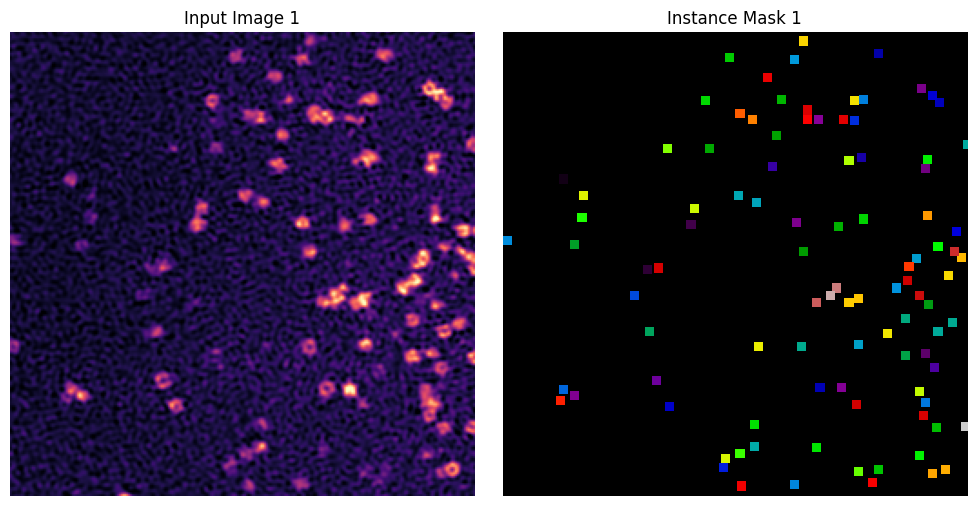

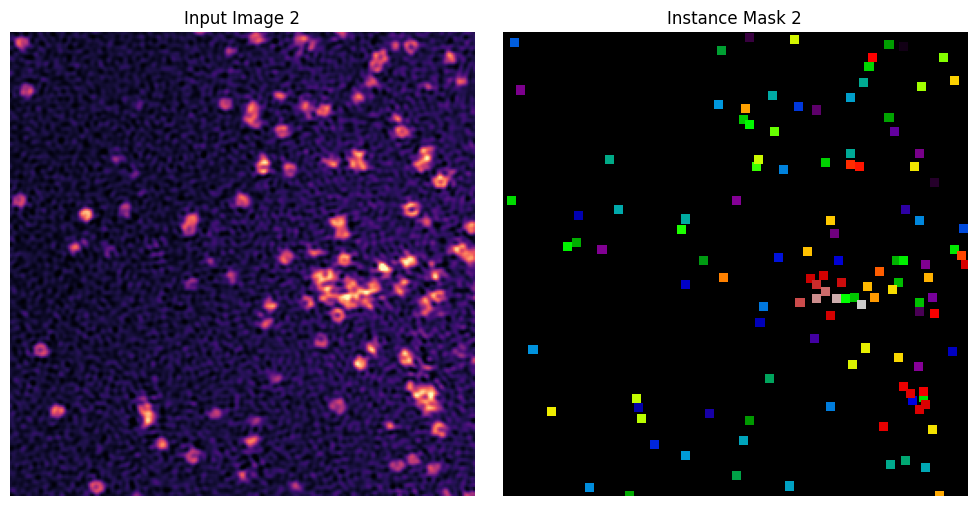

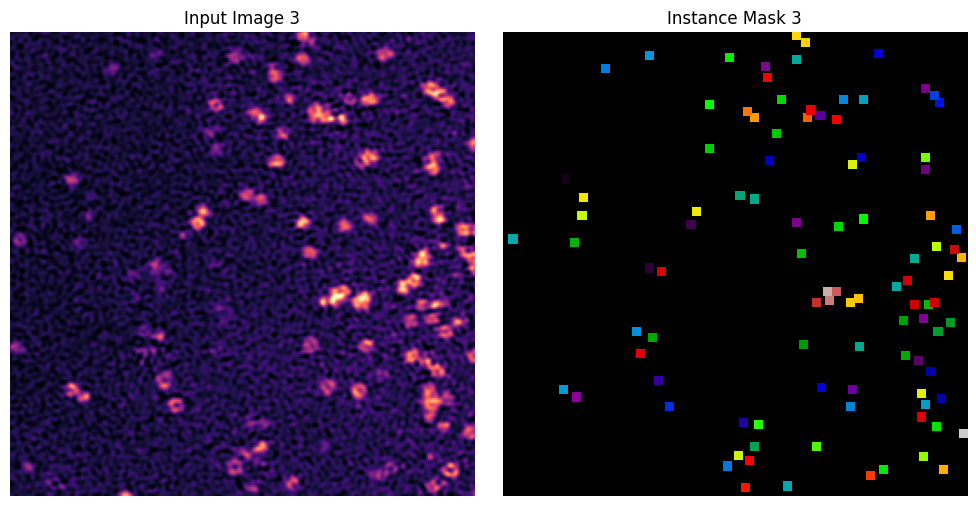

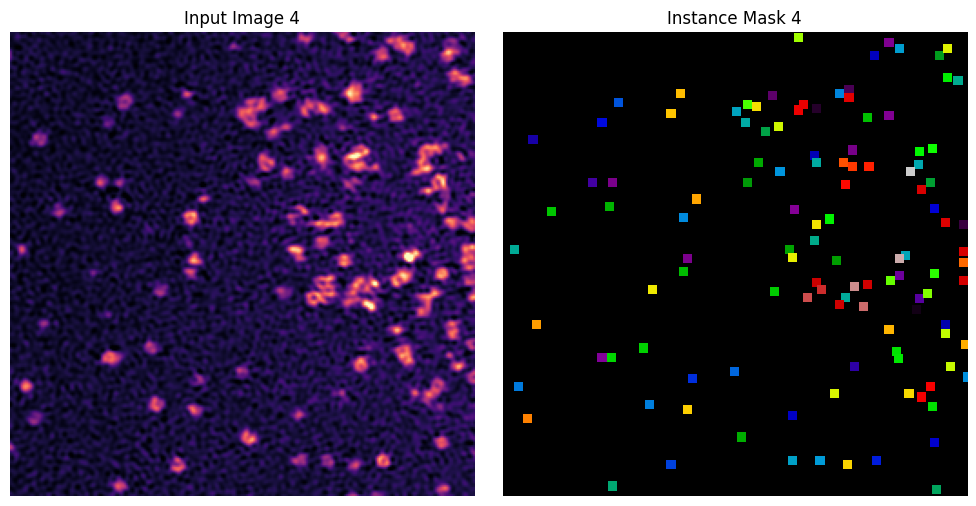

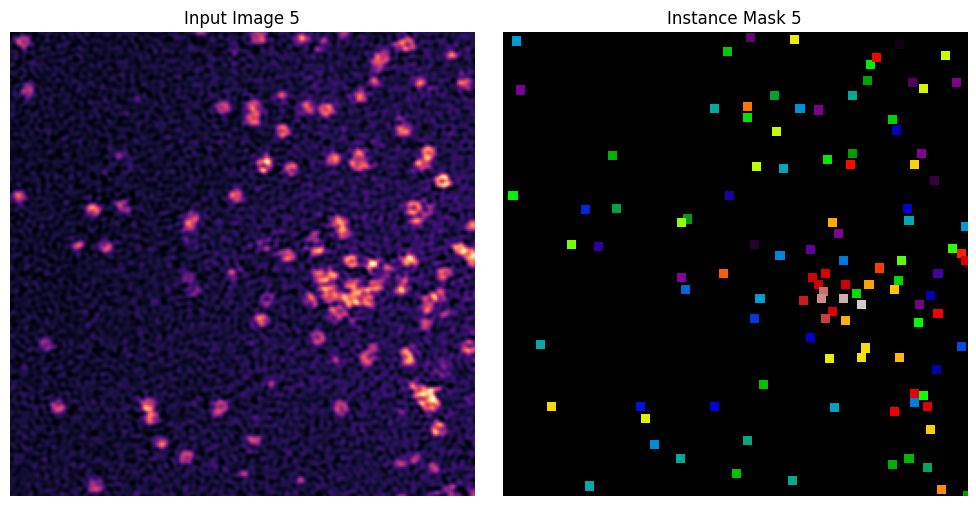

In [21]:
# Temporarily inspect the contents of the directories
print('Contents of real_training_data/images:')
!ls -F real_training_data/images/
print('\nContents of real_training_data/masks:')
!ls -F real_training_data/masks/

# Instantiate the dataset for the video data (which uses the Gaussian masks)
video_root = Path(OUT_DIR) / "video"
# Define GAUSSIAN_SIGMA for the previous plotting cell, if it's uncommented later
GAUSSIAN_SIGMA = 1.0 # Default value, adjust as needed
# Set mask_mode to 'label' to load the instance masks for visualization
train_dataset = AugmentedMicroscopyDataset(video_root, transform=get_val_transforms(), mask_mode="label")

# Create a DataLoader to easily get batches, though we'll just take individual samples
data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

num_samples_to_show = 5

print(f"Displaying {num_samples_to_show} random training samples with their instance masks:")

for i, (img_tensor, mask_tensor) in enumerate(data_loader):
    if i >= num_samples_to_show:
        break

    img = img_tensor.squeeze().cpu().numpy()
    mask = mask_tensor.squeeze().cpu().numpy()

    # Normalize image for display if it's not already 0-1
    if img.max() > 1:
        img = img / 255.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img, cmap='magma')
    axes[0].set_title(f"Input Image {i+1}")
    axes[0].axis('off')

    # Use a distinct colormap for integer labels to differentiate instances
    # and ensure values are correctly displayed (e.g., from 0 to max_label)
    axes[1].imshow(mask, cmap='nipy_spectral', interpolation='nearest')
    axes[1].set_title(f"Instance Mask {i+1}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [19]:
best_stardist_model = load_stardist_model_from_dir(best_model_dir)

def visualize_stardist_on_validation_sample(
    model,
    video_root: Path,
    video_map_path: Path,
    val_csv_path: str,
    norm_kwargs: Optional[dict] = None,
    prob_thresh: float = 0.5,
    nms_thresh: float = 0.3,
    num_samples: int = 2,
):
    norm_kwargs = _normalize_norm_kwargs(norm_kwargs) # Apply normalization kwargs conversion
    video_map_df = pd.read_csv(video_map_path)
    original_gt_coords = pd.read_csv(val_csv_path)
    img_paths = sorted((Path(video_root) / "images").glob("*"))

    if not img_paths:
        print("No validation images found in", video_root / "images")
        return

    selected_indices_in_dataset = np.random.choice(len(img_paths), min(num_samples, len(img_paths)), replace=False)

    for idx_in_dataset in selected_indices_in_dataset:
        img_path = img_paths[idx_in_dataset]
        filename = img_path.name
        real_frame_idx = video_map_df[video_map_df['filename'] == filename]['real_frame_idx'].iloc[0]

        # Load image and normalize for StarDist prediction
        img = _load_gray(img_path)
        img_norm = normalize(img, **norm_kwargs) if norm_kwargs else img

        # Get StarDist predictions (points)
        _, details = model.predict_instances(img_norm, prob_thresh=prob_thresh, nms_thresh=nms_thresh)
        pred_points_sd = details.get("points", [])

        px = [p[1] for p in pred_points_sd]
        py = [p[0] for p in pred_points_sd]

        # Get GROUND TRUTH centroids
        gt_points_for_frame = original_gt_coords[original_gt_coords['frame'] == real_frame_idx]
        gx = [row['x'] - ROI_X_MIN for _, row in gt_points_for_frame.iterrows()]
        gy = [row['y'] - ROI_Y_MIN for _, row in gt_points_for_frame.iterrows()]

        # Plotting
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img, cmap='gray')
        ax.scatter(gx, gy, s=35, facecolors='none', edgecolors='lime', linewidths=1.2, label='GT')
        ax.scatter(px, py, s=30, marker='x', color='red', linewidths=1.2, label='Pred (StarDist)')
        ax.set_title(f"Frame {real_frame_idx} Overlay: red=pred (x), green=gt (o)")
        ax.legend(loc='upper right')
        ax.axis('off')
        plt.tight_layout()
        plt.show()


visualize_stardist_on_validation_sample(
    model=best_stardist_model,
    video_root=video_root,
    video_map_path=video_map_path,
    val_csv_path=VAL_CSV,
    norm_kwargs=STARDIST_NORM_KW,
    prob_thresh=STARDIST_PROB_THRESH,
    nms_thresh=STARDIST_NMS_THRESH,
    num_samples=30 # Show 3 random samples
)


NameError: name 'load_stardist_model_from_dir' is not defined